In [1]:
import seaborn as sns
from matplotlib import pyplot as plt

import spacy
from spacy.training import Corpus

import os
import numpy as np
from pathlib import Path

In [2]:
FIGURES_DIR = Path("figures") / Path("confusion-matrices")
FIGURES_DIR.mkdir(exist_ok=True, parents=True)

SHORT_LABELS = ["osoba", "miasto", "kraj", "O"]

In [3]:
LEAST_CONF_MDIR = "../runs/least_confidence_50i_50n_kpwr-full_1669041142f2942019/models"
LEAST_CONF_MNAMES = [
    "model_2it_97spans.spacy",
    "model_14it_1020spans.spacy",
    "model_27it_2016spans.spacy",
    "model_41it_3040spans.spacy",
    "model_51it_3812spans.spacy"
]
LEAST_CONF_CLS_DISTRIB = [
    {"nam_liv_person": 44, "nam_loc_gpe_city": 19, "nam_loc_gpe_country": 34},
    {"nam_liv_person": 581, "nam_loc_gpe_city": 234, "nam_loc_gpe_country": 205},
    {"nam_liv_person": 1129, "nam_loc_gpe_city": 475, "nam_loc_gpe_country": 412},
    {"nam_liv_person": 1690, "nam_loc_gpe_city": 746, "nam_loc_gpe_country": 604},
    {"nam_liv_person": 2130, "nam_loc_gpe_city": 942, "nam_loc_gpe_country": 740}
]

In [4]:
RAND_MDIR = "../runs/random_50i_50n_kpwr-full_1669041088f13043/models"
RAND_MNAMES = [
    "model_2it_97spans.spacy",
    "model_14it_1023spans.spacy",
    "model_27it_2007spans.spacy",
    "model_40it_3005spans.spacy",
    "model_51it_3844spans.spacy"
]
RAND_CLS_DISTRIB = [
    {"nam_liv_person": 44, "nam_loc_gpe_city": 19, "nam_loc_gpe_country": 34},
    {"nam_liv_person": 527, "nam_loc_gpe_city": 263, "nam_loc_gpe_country": 233},
    {"nam_liv_person": 1075, "nam_loc_gpe_city": 510, "nam_loc_gpe_country": 422},
    {"nam_liv_person": 1663, "nam_loc_gpe_city": 750, "nam_loc_gpe_country": 592},
    {"nam_liv_person": 2153, "nam_loc_gpe_country": 725, "nam_loc_gpe_city": 966}
]

In [5]:
TEST_DB = "../data/inzynierka-kpwr-test-3-full.spacy"
_temp_nlp = spacy.load(os.path.join(RAND_MDIR, RAND_MNAMES[0]))
test_corpus = tuple(Corpus(TEST_DB)(_temp_nlp))

/home/jjamnicki/miniconda3/envs/bachelor_tp_visuals/lib/python3.8/site-packages/spacy/util.py:877: UserWarning: [W095] Model 'pl_pipeline' (0.0.0) was trained with spaCy v3.4 and may not be 100% compatible with the current version (3.4.2). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [6]:
SPANS_KEY = "sc"
label_idxs = {"nam_liv_person": 0, "nam_loc_gpe_city": 1,
                "nam_loc_gpe_country": 2, "O": 3}
 # order of labels in the confusion matrix
ticklabels = ["nam_liv_person", "nam_loc_gpe_city", "nam_loc_gpe_country", "O"]
actual_short_labels = ["osoba", "miasto", "kraj", "nieznane"]
predicted_short_labels = ["osoba", "miasto", "kraj"]

def get_spans_confusion_matrix(test_corpus, predictions, spans_key, label_idxs):
    n_labels = len(label_idxs)
    cm = np.zeros(shape=(n_labels, n_labels))
    for actual, pred in zip(test_corpus, predictions):
        actual_spans = actual.to_dict()["doc_annotation"]["spans"]
        pred_spans = pred.spans
        if not actual_spans or not pred_spans:
            continue
        for actual_span in actual_spans[spans_key]:
            actual_label = actual_span[2]
            found = False
            for pred_span in pred_spans[spans_key]:
                if actual_span[0] == pred_span.start_char \
                        and actual_span[1] == pred_span.end_char:
                    pred_label = pred_span.label_
                    cm[label_idxs[actual_label]][label_idxs[pred_label]] += 1
                    found = True
            if not found:
                cm[label_idxs[actual_label]][label_idxs["O"]] += 1
    return cm

## Confusion matrixes comparison of sampling strategies models

rand_model_2it_97spans.spacy


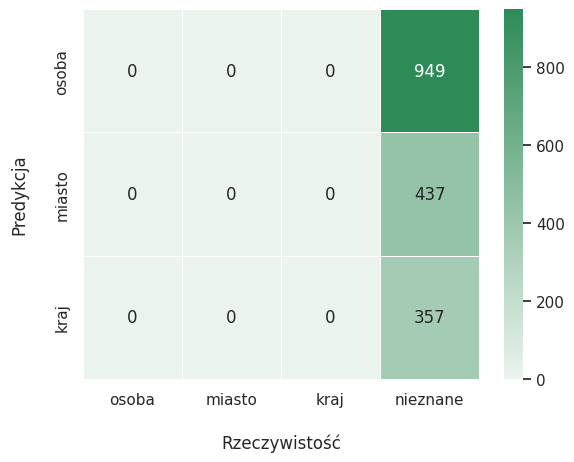

lconf_model_2it_97spans.spacy


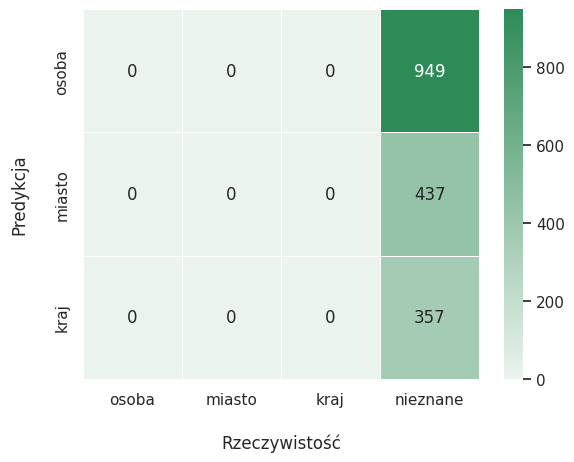

rand_model_14it_1023spans.spacy


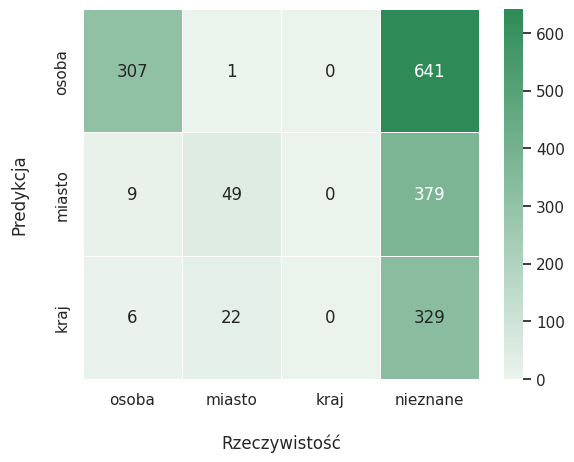

lconf_model_14it_1020spans.spacy


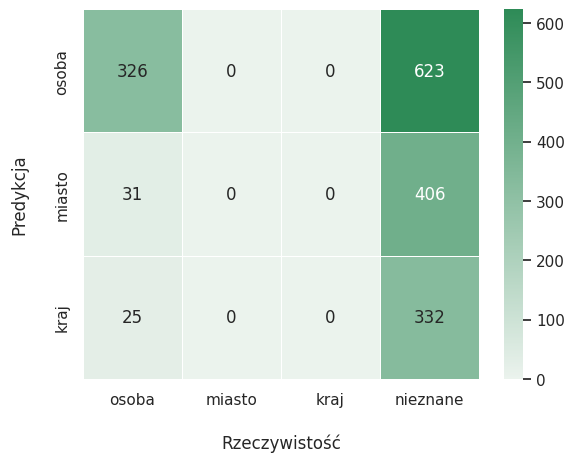

rand_model_27it_2007spans.spacy


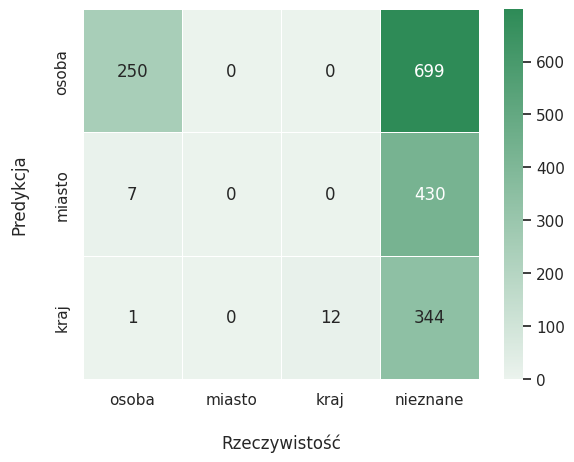

lconf_model_27it_2016spans.spacy


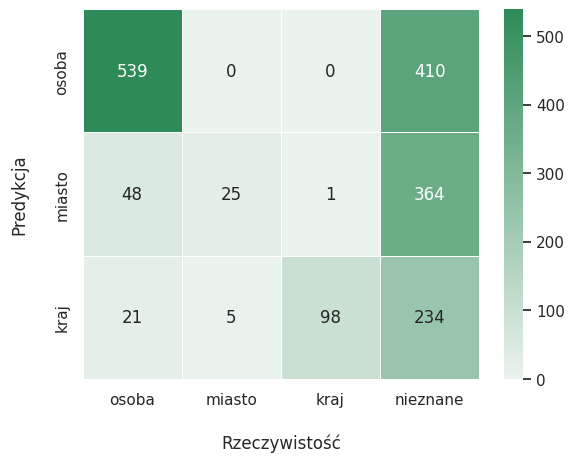

rand_model_40it_3005spans.spacy


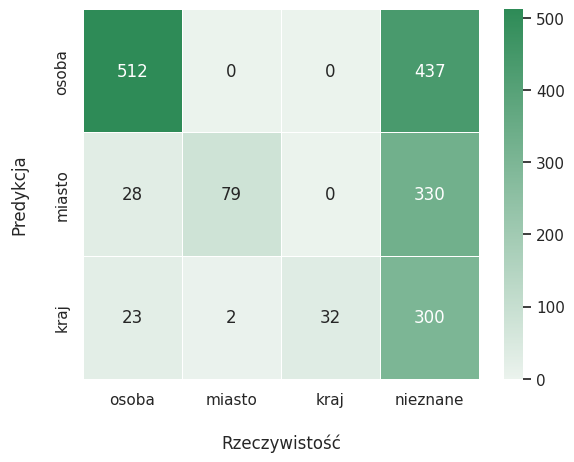

lconf_model_41it_3040spans.spacy


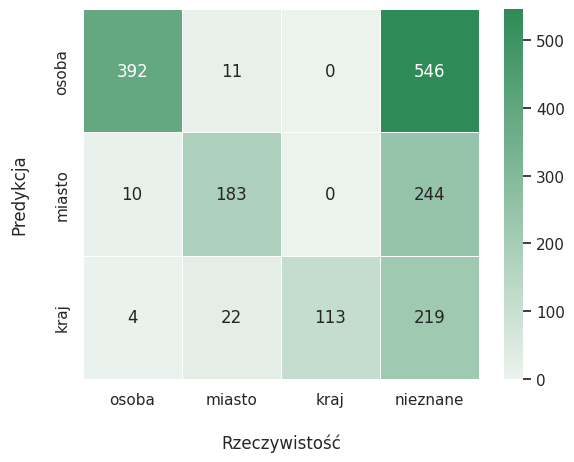

rand_model_51it_3844spans.spacy


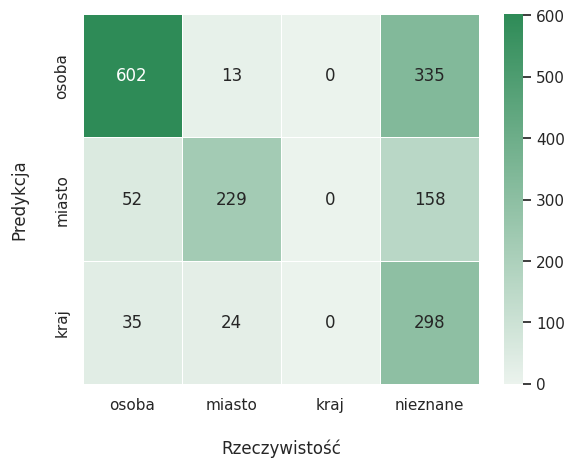

lconf_model_51it_3812spans.spacy


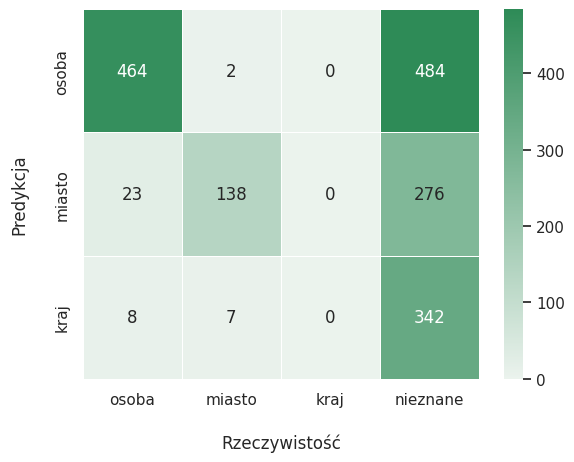

In [7]:
sns.set(font_scale=1)
cmap = sns.light_palette("seagreen", as_cmap=True)

texts = [example.text for example in test_corpus]
for rand_mname, lconf_mname, rand_cls_dist, lconf_cls_dist in zip(
        RAND_MNAMES, LEAST_CONF_MNAMES,
        RAND_CLS_DISTRIB, LEAST_CONF_CLS_DISTRIB
):
    rand_mpath = os.path.join(RAND_MDIR, rand_mname)
    rand_nlp = spacy.load(rand_mpath)
    rand_preds = rand_nlp.pipe(texts)
    rand_cm = get_spans_confusion_matrix(test_corpus, rand_preds,
                                         SPANS_KEY, label_idxs)
#     rand_cm = rand_cm.astype('float') / rand_cm.sum(axis=1)[:, np.newaxis]
    rand_cm = rand_cm[:-1]

    rand_hm = sns.heatmap(rand_cm, annot=True, cmap=cmap, linewidth=0.5,
                         fmt="0.0f", xticklabels=actual_short_labels,
                         yticklabels=predicted_short_labels)
    rand_hm.set(xlabel="\nRzeczywistość", ylabel="Predykcja\n")

    plt.savefig(FIGURES_DIR / f"pl_rand_conf_matrix_{rand_mname}.svg")
    print("rand_" + rand_mname)
    plt.show()

    lconf_mpath = os.path.join(LEAST_CONF_MDIR, lconf_mname)
    lconf_nlp = spacy.load(lconf_mpath)
    lconf_preds = lconf_nlp.pipe(texts)
    lconf_cm = get_spans_confusion_matrix(test_corpus, lconf_preds,
                                          SPANS_KEY, label_idxs)
#     lconf_cm = lconf_cm.astype('float') / lconf_cm.sum(axis=1)[:, np.newaxis]
    lconf_cm = lconf_cm[:-1]

    lconf_hm = sns.heatmap(lconf_cm, annot=True, cmap=cmap, linewidth=0.5,
                          fmt="0.0f", xticklabels=actual_short_labels,
                          yticklabels=predicted_short_labels)
    lconf_hm.set(xlabel="\nRzeczywistość", ylabel="Predykcja\n")

    print("lconf_" + lconf_mname)
    plt.savefig(FIGURES_DIR / f"pl_lconf_conf_matrix_{lconf_mname}.svg")
    plt.show()

